#  Data Analysis on a WhatsApp Group Chat


## *Steps*

- Data Preprocessing 
- Exploratory Data Analysis
- Data Visualization 
- Data Interpretation
- Summarizing the Inferences
- Conclusion

# *Importing Necessary Libraries*

We will be using :
1. **Regex (re)** to extract and manipulate strings based on specific patterns.
2. **pandas** for analysis.
3. **matlotlib** and **seaborn** for visualization.
4. **emoji** to deal with emojis.
5. **wordcloud** for the most used words.

In [1]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools 
from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

## *Preparation and reading data*

In [2]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

In [44]:
df = rawToDf('WhatsAppChat.txt', '12hr')


 This is my most active college coding group. It has **235+** participants; 237 to be precise.
 This group was made in **January 2022.**

## Pre-Processing

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13596 entries, 0 to 13595
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  13596 non-null  datetime64[ns]
 1   user       13596 non-null  object        
 2   message    13596 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 318.8+ KB


#### The dataset contains 3 rows, and 13655 respective entries.


In [46]:
df.sample(10)

,date_time,user,message
9004,2022-07-19 13:07:00,Tushar Nankani,<Media omitted>
2478,2022-03-01 10:54:00,+91 79770 56210,👍🏻
10341,2022-08-24 15:11:00,Darshan Rander IT,Ye F likhna band karo bhai🤦‍♂️🤦‍♂️
8703,2022-07-10 19:31:00,+91 97681 67131,"Did u first try installing homebrew, wait I’ll..."
2169,2022-02-25 17:39:00,Tanay Kamath CE,"As far as what Ik,they told us that F.Es will ..."
10286,2022-08-24 13:19:00,+91 88284 70904,Light gaya tha lol
289,2022-01-28 19:24:00,Tanay Kamath CE,printf function always returns a value equal ...
6733,2022-05-28 03:28:00,Dheeraj Lalwani CE,It's a shop!😅
8306,2022-07-01 17:48:00,Tanay Kamath CE,This message was deleted
4192,2022-03-30 21:15:00,Saket CE,yes same condition required


#### One might wonder there are no NaNs, but as you can see, there are some rows, where messages are an *empty string.*
- This can be because, the message might just contain **emojis.**


In [47]:
df[df['message'] == ""].shape[0]

533

#### *Fatching data from date_time for analysis and visualization*

In [51]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())


### Final Data Frame

In [52]:
df

,date_time,user,message,day,month,year,date
0,2022-01-26 16:19:00,group_notification,Messages and calls are end-to-end encrypted. N...,Wed,Jan,2022,2022-01-26
1,2022-01-24 20:25:00,group_notification,"Tanay Kamath CE created group ""CODERS👨‍💻👩‍💻🖥💻""",Mon,Jan,2022,2022-01-24
2,2022-01-26 16:19:00,group_notification,You joined using this group's invite link,Wed,Jan,2022,2022-01-26
3,2022-01-26 16:20:00,group_notification,+91 99871 38558 joined using this group's invi...,Wed,Jan,2022,2022-01-26
4,2022-01-26 16:20:00,group_notification,+91 91680 38866 joined using this group's invi...,Wed,Jan,2022,2022-01-26
...,...,...,...,...,...,...,...
13591,2022-10-02 02:05:00,Darshan Rander IT,MCQs mark kiya,Sun,Oct,2022,2022-10-02
13592,2022-10-02 02:05:00,Darshan Rander IT,Sign-in kiya😂😅,Sun,Oct,2022,2022-10-02
13593,2022-10-02 02:11:00,Tanay Kamath CE,Incognito se na?,Sun,Oct,2022,2022-10-02
13594,2022-10-02 02:28:00,Darshan Rander IT,Yup,Sun,Oct,2022,2022-10-02


# *Data Analysis*

**1. Overall frequency of total messages on the group.**

**2. Top 10 most active days.**

**3. Top 10 active users on the group (with a twist).**
- Ghosts present in the group. (shocking results.)

**4. Top 10 users most sent media.**

**5. Top 10 most used emojis.**

**6. Most active hours and days.**
 - Heatmaps of weekdays and months.
 - Most active hours, weekdays, and months.

**7. Most used words - WordCloud**

# 1. Overall frequency of total messages on the group.
- I will first do this to get a look at overall data.
I will plot a simple line graph to see the frequency of messages over the months.


In [54]:
df1 = df.copy()      # I will be using a copy of the original data frame everytime, to avoid loss of data!
df1['message_count'] = [1] * df1.shape[0]      # --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns 
df1 = df1.groupby('date').sum().reset_index()  # grouping by date; --> no. of messages / day.
df1

,date,message_count
0,2022-01-24,1
1,2022-01-26,105
2,2022-01-27,90
3,2022-01-28,126
4,2022-01-29,118
...,...,...
236,2022-09-28,144
237,2022-09-29,49
238,2022-09-30,167
239,2022-10-01,91


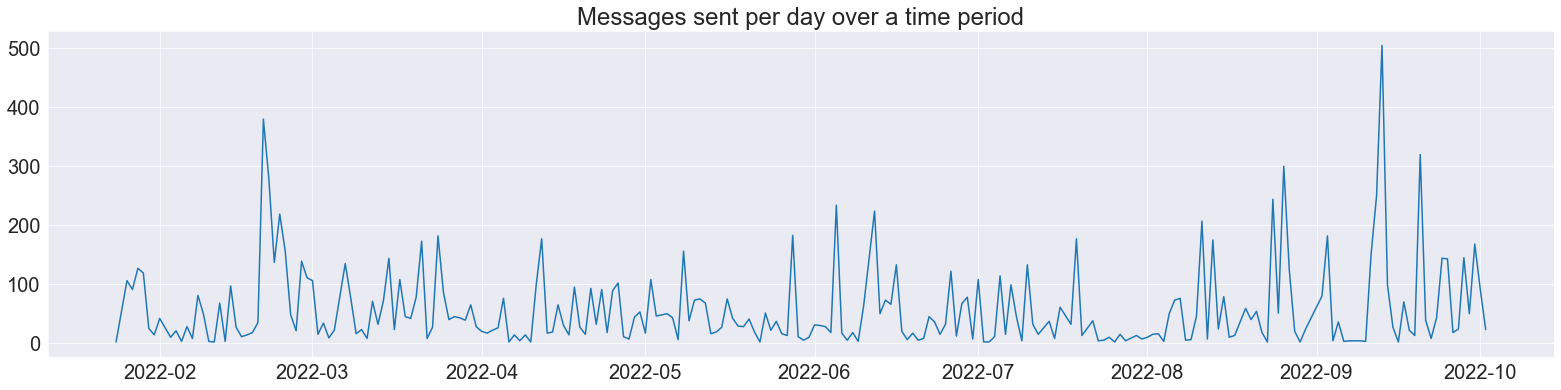

In [55]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);   


# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')

## 2 *Top 10 most active days.*

In [56]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,message_count
0,2022-09-13,504
1,2022-02-20,379
2,2022-09-20,319
3,2022-08-26,299
4,2022-02-21,278
5,2022-09-12,249
6,2022-08-24,243
7,2022-06-05,233
8,2022-06-12,223
9,2022-02-23,218


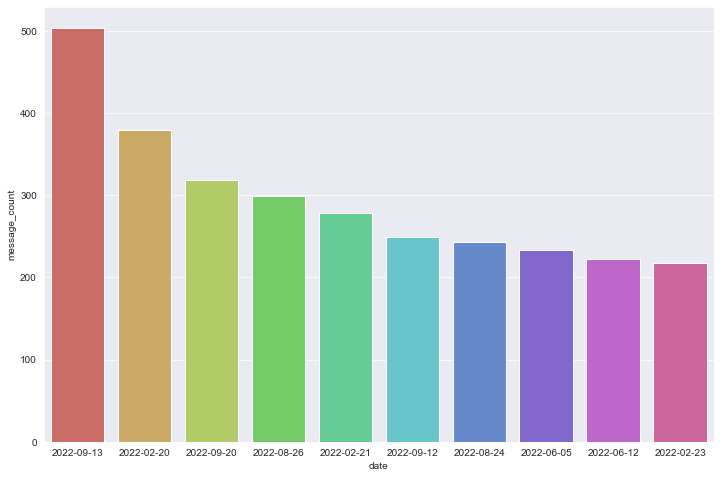

In [57]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)

# A bar plot for top 10 days
sns.barplot(top10days.date, top10days.message_count, palette="hls");

# Saving the plots
plt.savefig('top10_days.svg', format = 'svg')

#### Apparently, the group was very active on 13th Spetember'22
- Because we were discussing fundamental yet tricky and brain-wracking "Guess the Output" Java questions!

## 3. Top 10 active users on the group.

### Before, analysing that, we will see the *number of Ghosts* in the group.

In [58]:
# Total number of people who have sent at least one message on the group;
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {237 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 154
Number of people who haven't sent even a single message on the group are 81


### *Shocking Result*
- Total number of people who have sent at least one message on the group are **154**.
- BUT, the total number of participants were **237**.
- **That means 81 people in the group have not sent even a single message throughout these 9 months and 13500+ messages.**

### Now, pre-processing top 10 active users.

In [60]:
df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,Tanay Kamath CE,2525
1,Dheeraj Lalwani CE,1934
2,Darshan Rander IT,1385
3,Kartik Soneji CE,829
4,"Harsh Kapadia (TSEC IT, SE)",790
5,"Pratik K (TSEC CS, SE)",778
6,"Saurav Upoor (TSEC CS, SE)",564
7,Tushar Nankani,353
8,+91 82916 21138,275
9,"Farhan Irani (TSEC IT, SE)",248


## Now, visualizing top 10 active users.
### *Replacing names with initials for better visualization*

In [61]:
top10df['initials'] = ''
for i in range(10):
    top10df.initials[i] = top10df.user[i].split()[0][0] + top10df.user[i].split()[1][0]
    
top10df.initials[7] = "Me"    # That's me
top10df.initials[8] = "DT"

### Starting with a basic plot.



In [62]:
# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## *Now, I will be trying different visualization methods.*

##### Plotting a simple line graph.

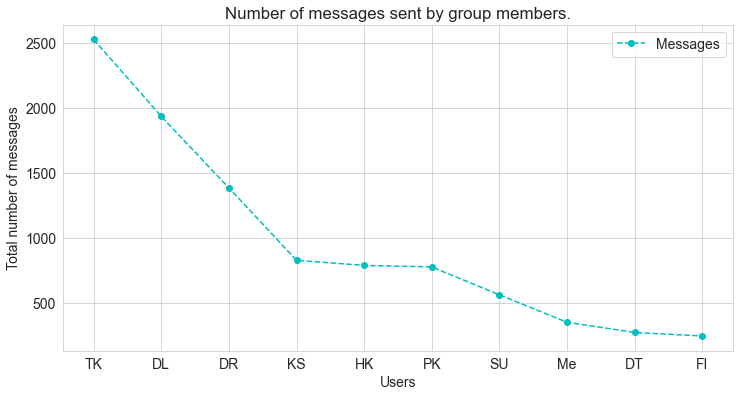

In [63]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))


# plt.plot(top10df.initials, top10df.message, marker='o', ls='--', c='cyan')

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.initials, top10df.message, 'o--c')  


# Labels and Title 
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);

# Saving the plots
# plt.savefig('msg_plots.svg', format = 'svg')

#### *Plotting a bar chart and line graph together.*

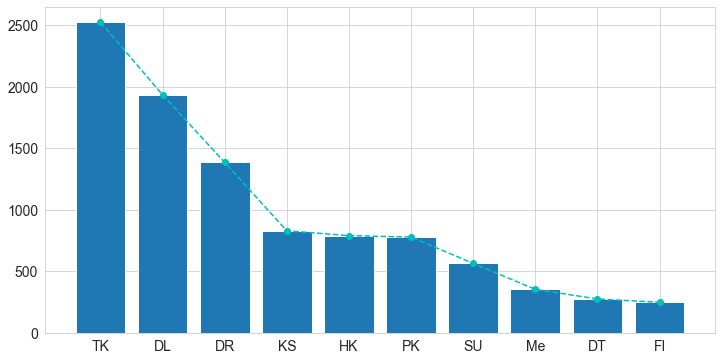

In [64]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))

plt.bar(top10df.initials, top10df.message)   # basic bar chart
plt.plot(top10df.initials, top10df.message, 'o--c');   # line chart

### *Beautifying Default Styles using Seaborn*

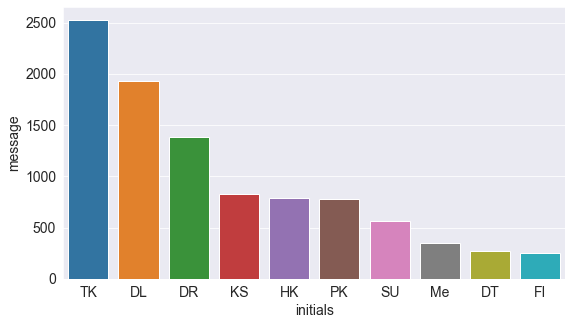

In [65]:
# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")
sns.barplot(top10df.initials, top10df.message, data=top10df);

# *Important Note*

- Since almost all the plots will be ***comparing* one person with another**, I’ll assign a **specific colour to each person** so that it becomes **easy to identify** each person among *multiple plots*. 

- I could've used *seaborn's color palette* but:
    - Seaborn assigns default colors itself, but i wanted the color of a **certain person remains the same, no matter the plot**;
    - Also, I wanted to try some different colors so I grabbed my **colour palette** from https://coolors.co/

- Next, I made a dictionary where each key is the name and the value for each would be their assigned colour. I create a function which reorders colours given a list of names to match the ordering of the plot. This function takes the ordered names as input and returns a reordered list of colours. This list has to be passed into the `pallete` argument in a seaborn plotting function.

## Defining a function to tackle the problem.

I'm defining the following function to ***maintain consistent colors for each person across all plots***. Since the order will vary depending on the plot, this is passed to the function which will reorder colors in a particular order so that **the color of a certain person remains the same no matter the plot**. This will help maintain **consistency and readability** amongst the many graphs I will be plotting.


In [66]:
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''
    
    order = list(names_in_certain_order)
    return_list = []
    
    for name in order:
        return_list.append(color_dict[name])
        
    return return_list

### Now, we have a really nice set of colours for each person, with which we can visualize using `sns.palplot`.

{'TK': '#F94144',
 'DL': '#F3722C',
 'DR': '#F8961E',
 'KS': '#FDC500',
 'HK': '#F9C74F',
 'PK': '#90BE6D',
 'SU': '#43AA8B',
 'Me': '#577590',
 'DT': '#6D597A',
 'FI': '#003F88'}

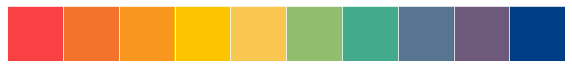

In [67]:
colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#003F88']
sns.palplot(colors)    # visualizing the colors' list

names = top10df.initials

color_dict = {}
for name, color in zip(names, colors):
    color_dict[name] = color
color_dict

## Now, finding the *average message length* of the 10 most active users of the group.

In [68]:
# Adding another column for message length; using the apply method;
df2['message_length'] = df2['message'].apply(lambda x: len(x))      

# Creating another dataframe for average length per user;
avg_msg_lengths = df2.groupby(df2.user).mean().reset_index().sort_values(by = 'message_length', ascending = False)

# Creating helper columns;
top10df['avg_message_length'] = [0] * 10
i, j = 0, 0
while i < 10:
    if top10df['user'][i] == avg_msg_lengths['user'][j]:
        top10df['avg_message_length'][i] = avg_msg_lengths['message_length'][j]
        i += 1
        j = -1
    j += 1

# Sorting the average message lengths of the same to 10 active users;
top10df_msg = top10df.sort_values(by = "avg_message_length", ascending=False)

## Now, we will be plotting *most sent messages* and respective *average message lengths* simultaneously, to see some interesting results.
- Plotting multiple charts in a grid
    - Matplotlib and Seaborn also support plotting multiple charts in a grid, using `plt.subplots`, which returns a set of axes that can be used for plotting.

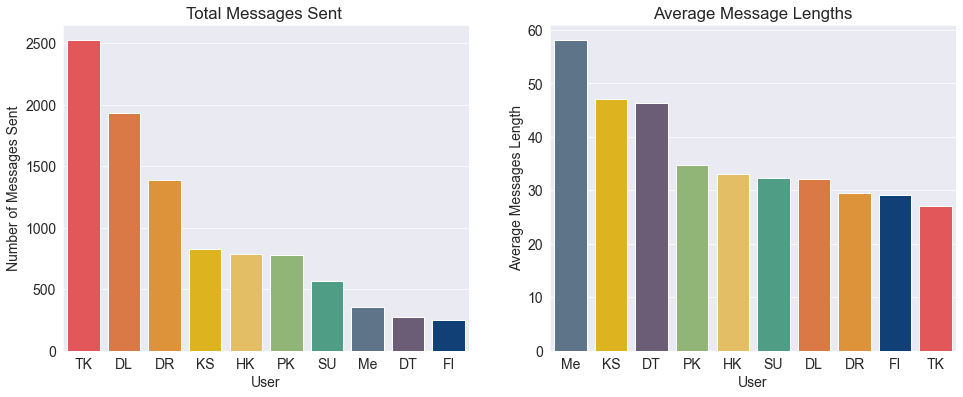

In [69]:
# plotting multiple charts in a grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("darkgrid")

# Plot 1 - Countplot of total messages sent
sns.barplot(top10df.initials, top10df.message, data=top10df, ax = axes[0], palette=get_colors_of_certain_order(top10df.initials));     # Note: the palette argument;

axes[0].set_title('Total Messages Sent ')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')



# Plot 2 - Barplot of those top 10 users' average message lengths
sns.barplot(top10df_msg.initials, top10df_msg.avg_message_length, ax = axes[1], palette = get_colors_of_certain_order(top10df_msg.initials))    # Note: the respective palette argument;

axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User');
axes[1].set_ylabel('Average Messages Length');

# Saving the plots
plt.savefig('top10_msg_plots_diff.svg', format = 'svg')

### It’s really interesting to see plots like this *side by side*, because here comes the twist:

- Ironically, **TK**, the person who sent the **most amount of texts** (2000+), has ***least*** messages' length on *average*. This means this person sends broken and many WhatsApp messages in one go. 

- We can see that, **I** send less number of messages while having a **relatively longer message length**, followed by **KS**.

- Here's a **snippet** of how TK sends messages:



#### "*Things aren't always the way they seem like.*"

# 4. Top 10 users most sent media 

- The exported chats were exported without any media files. Any message that contained media was indicated with `‘<Media Omitted> ’`. 

### *Pre-processing*
**We can use this to filter out and see who sends the most media.**

In [70]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

top10media['initials'] = ''
for i in range(10):
    top10media.initials[i] = top10media.user[i].split()[0][0] + top10media.user[i].split()[1][0]

top10media.initials[2] = "Me"    # That's me
top10media.initials[9] = "VR"


###### QUICK HACK
- to get **all possible Seaborn's color palettes**:
    - Just put a random input `palette="xyz"`
    - It will then show an error, showing all possible palettes you can try out from!

### Which user sends the most media?

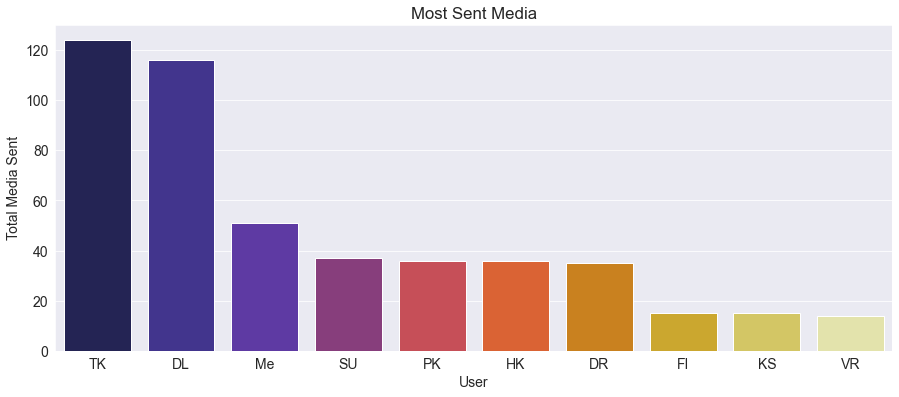

In [71]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting a bar graph;
sns.barplot(top10media.initials, top10media.media_sent, palette="CMRmap");

plt.title('Most Sent Media')
plt.xlabel('User')
plt.ylabel('Total Media Sent');

# Saving the plots
plt.savefig('top10media.svg', format = 'svg')

### **TK** is beating everyone by a mile, followed by **DL**. He also ranks the **top** in total messages, *though **last** in average message length*. Most dedicated contributor award goes to **TK**!

# 5. Top 10 most used Emojis
- Will be using the `emoji` module, that was imported earlier.

In [76]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    emojis_found = r.findall(row["message"])
    for emoji_found in emojis_found:
        emoji_ctr[emoji_found] += 1

AttributeError: module 'emoji' has no attribute 'UNICODE_EMOJI'

['👨\u200d💻', '👩\u200d💻', '💻', '🖥']

#### Will create another helper column using `emoji.demojize("<emoji>")`, since emojis will not rendered.

In [73]:
top10emojis = pd.DataFrame()
# top10emojis = pd.DataFrame(data, columns={"emoji", "emoji_description", "emoji_count"}) 
top10emojis['emoji'] = [''] * 10
top10emojis['emoji_count'] = [0] * 10
top10emojis['emoji_description'] = [''] * 10

i = 0
for item in emoji_ctr.most_common(10):
    # will be using another helper column, since during visualization, the emojis won't be rendered.
    description = emoji.demojize(item[0])[1:-1]    # using `[1:-1]` to remove the colons ':' at the end of the demojized strin
    
    # appending top 10 data of emojis.  # Loading into a DataFrame.
    top10emojis.emoji[i] = item[0]
    top10emojis.emoji_count[i] = int(item[1])
    top10emojis.emoji_description[i] = description
    i += 1

top10emojis

,emoji,emoji_count,emoji_description
0,,0,
1,,0,
2,,0,
3,,0,
4,,0,
5,,0,
6,,0,
7,,0,
8,,0,
9,,0,


### Which Emoji is the most used in the chat?

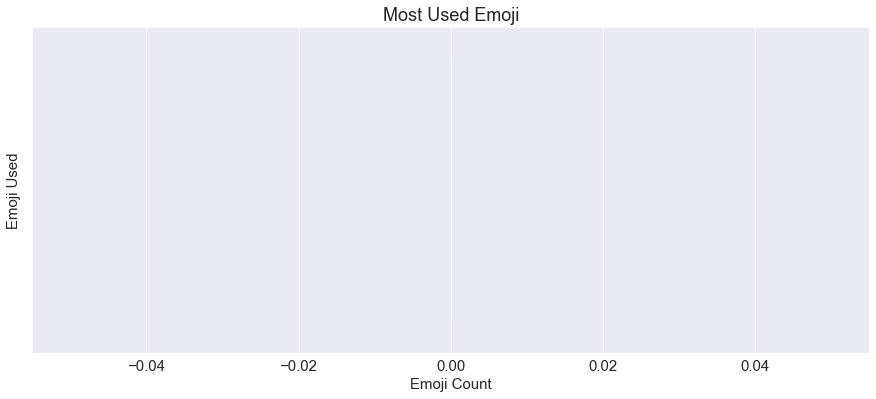

In [74]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 15

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;
sns.barplot(top10emojis.emoji_count, top10emojis.emoji_description, palette = "Paired_r")

plt.title('Most Used Emoji')
plt.xlabel('Emoji Count')
plt.ylabel('Emoji Used');

# Saving the plots
plt.savefig('top10emoji.svg', format = 'svg')

#### Not that it is worth anything, but "😂" beats everyone by a huge margin!

# 6. Most active days, most active hours, most active months.

### *Pre-processing*

In [34]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # helper column to keep a count.

df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

### Which hour of the day are most messages exchanged?

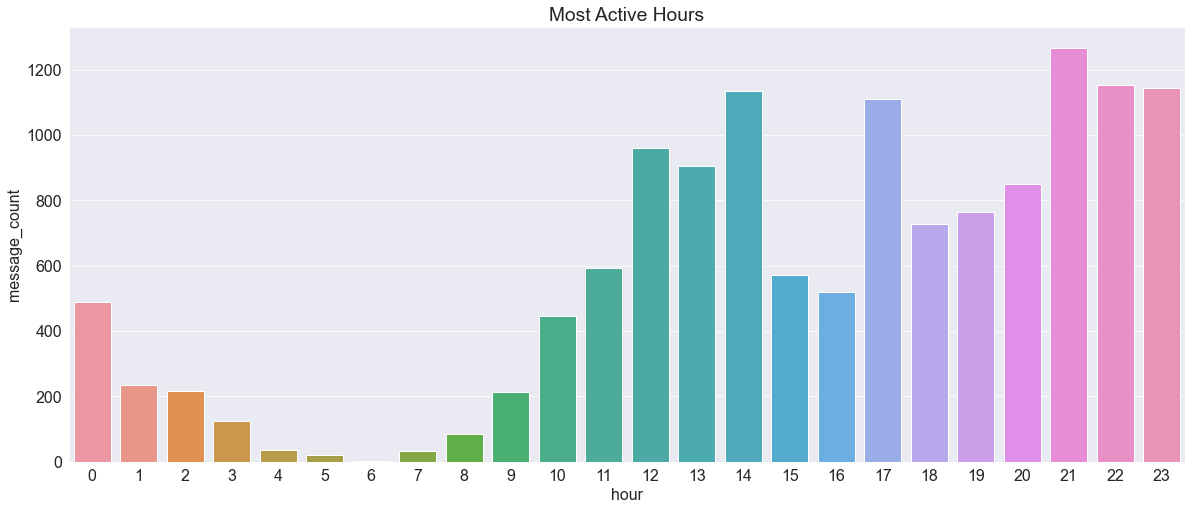

In [35]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 8)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: grouped by hour
sns.barplot(grouped_by_time.hour, grouped_by_time.message_count)
plt.title('Most Active Hours');

# Saving the plots;
plt.savefig('most_active_hours.svg', format = 'svg')

#### Intrestingly, the group is *most active around midnight*, followed by *afternoon*.

### *Pre-processing weekdays and months*

In [36]:
# specific `order` to be printed in;
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# grouping by day;
grouped_by_day = df3.groupby('day').sum().reset_index()[['day', 'message_count']]


# specific `order` to be printed in;
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till Septemeber
# grouping by month;
grouped_by_month = df3.groupby('month').sum().reset_index()[['month', 'message_count']]


## *Visualization*
### Now, we will be plotting *grouped by day* and respective *group by month* simultaneously, to see some interesting results.
- Using `plt.subplots` to plot multiple charts in a grid.

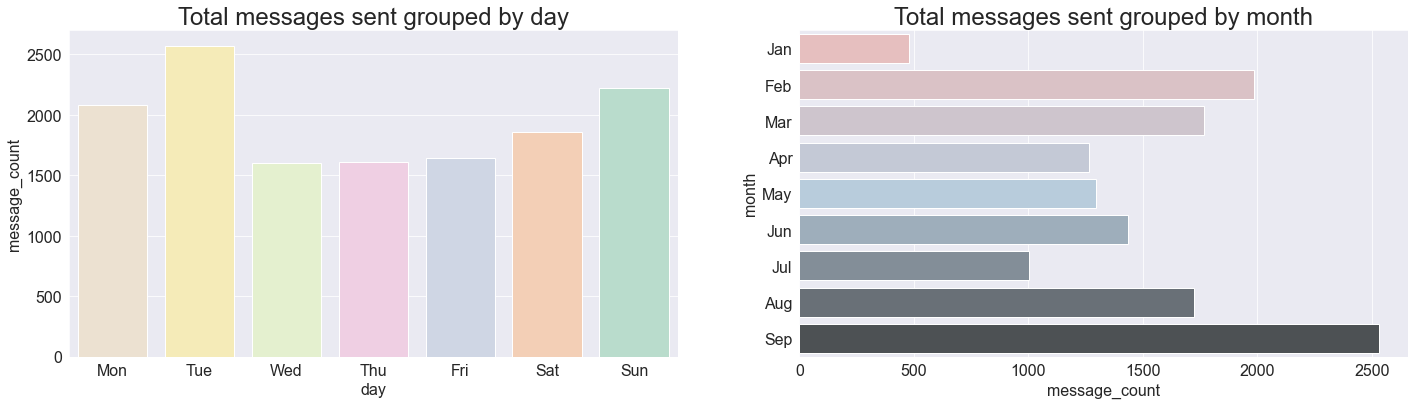

In [37]:
fig, axs = plt.subplots(1, 2, figsize = (24, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 20

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;

# PLOT 1: Messages grouped by weekday
sns.barplot(grouped_by_day.day, grouped_by_day.message_count, order=days, ax = axs[0], palette='Pastel2_r')
axs[0].set_title('Total messages sent grouped by day')

# PLOT 2: Messages grouped by months
sns.barplot(y = grouped_by_month.month, x=grouped_by_month.message_count, order = months, ax = axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month');

# Saving the plots;
plt.savefig('days_and_month.svg', format = 'svg')

##### The group is most active on Sundays, and least active on Mondays (probably *Monday Blues*)
##### It has been recently very active, in September.

### Now, we will plot a *heatmap*, combining the above to bar plots, for a better understanding! 

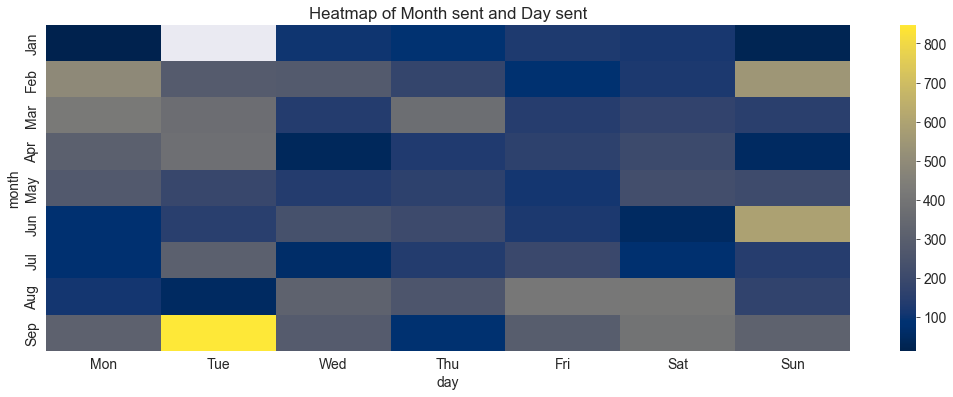

In [38]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18, 6)

# Beautifying Default Styles using Seaborn,
sns.set_style("darkgrid")

# Pre-Processing by month and day,
grouped_by_month_and_day = df3.groupby(['month', 'day']).sum().reset_index()[['month', 'day', 'message_count']]

# creating a pivot table,
pt = grouped_by_month_and_day.pivot_table(index = 'month', columns = 'day', values = 'message_count').reindex(index = months, columns = days)

# PLOT: heatmap.
sns.heatmap(pt, cmap = 'cividis');
plt.title('Heatmap of Month sent and Day sent');

# Saving the plots;
plt.savefig('month_day_heatmap.svg', format = 'svg')

# *Inferences*
- The group is more active on weekends, throughout the months.
- September has the most lighter blue shades and more yellow gradients.
- This gives a combined analysis, which is really helpful in real-time projects.

# Most used words in the chat.
### Finally, I will be ending with *the most used words*, using `WordCloud` module in Python.

In [39]:
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in df3.message.values:
    
    # typecaste each val to string.
    val = str(val) 
    
    # split the value.
    tokens = val.split() 
    
    # Converts each token into lowercase.
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 8).generate(comment_words) 

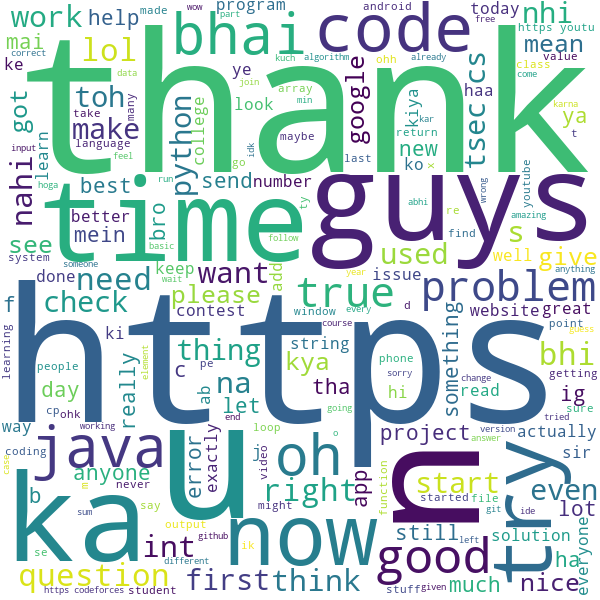

In [40]:
wordcloud.to_image()

# *Conclusion*

- The insights were really interesting to look at!

- We first loaded the data as a .txt file coverted it using `RawtoDF` function.
- Then  we added helper columns, manipulated datetime entries.
- Then, we started analysing our whatsapp data!

Here is what we looked at!

**1. Overall frequency of total messages on the group.**

**2. Top 10 most active days.**

**3. Top 10 active users on the group (with a twist - Most active user had the least average message length ).**
- Ghosts present in the group. (shocking results - 80+ participants who haven't even sent a single message!)

**4. Top 10 users most sent media.**
- *TK* beats everyone by a mile!

**5. Top 10 most used emojis.**
- using the `emoji` module!

**6. Most active hours and weekdays.**
 - Heatmaps of weekdays and months.
 - Most active hours, weekdays, and months.

**7. Most used words - WordCloud**

### That's it from my end! I *learnt and enjoyed* a lot!

# *Thank You*
